In [5]:
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [6]:
class PSAR:
    def __init__(self, init_af=0.02, max_af=0.2, af_step=0.02):
        self.max_af = max_af
        self.init_af = init_af
        self.af = init_af
        self.af_step = af_step
        self.extreme_point = None
        self.high_price_trend = []
        self.low_price_trend = []
        self.high_price_window = deque(maxlen=2)
        self.low_price_window = deque(maxlen=2)

        # Lists to track results
        self.psar_list = []
        self.af_list = []
        self.ep_list = []
        self.high_list = []
        self.low_list = []
        self.trend_list = []
        self._num_days = 0

    def calcPSAR(self, high, low):
        if self._num_days >= 3:
            psar = self._calcPSAR()
        else:
            psar = self._initPSARVals(high, low)

        psar = self._updateCurrentVals(psar, high, low)
        self._num_days += 1

        return psar

    def _initPSARVals(self, high, low):
        if len(self.low_price_window) <= 1:
            self.trend = None
            self.extreme_point = high
            return None

        if self.high_price_window[0] < self.high_price_window[1]:
            self.trend = 1
            psar = min(self.low_price_window)
            self.extreme_point = max(self.high_price_window)
        else:
            self.trend = 0
            psar = max(self.high_price_window)
            self.extreme_point = min(self.low_price_window)

        return psar

    def _calcPSAR(self):
        prev_psar = self.psar_list[-1]
        if self.trend == 1:  # Up
            psar = prev_psar + self.af * (self.extreme_point - prev_psar)
            psar = min(psar, min(self.low_price_window))
        else:
            psar = prev_psar - self.af * (prev_psar - self.extreme_point)
            psar = max(psar, max(self.high_price_window))

        return psar

    def _updateCurrentVals(self, psar, high, low):
        if self.trend == 1:
            self.high_price_trend.append(high)
        elif self.trend == 0:
            self.low_price_trend.append(low)

        psar = self._trendReversal(psar, high, low)

        self.psar_list.append(psar)
        self.af_list.append(self.af)
        self.ep_list.append(self.extreme_point)
        self.high_list.append(high)
        self.low_list.append(low)
        self.high_price_window.append(high)
        self.low_price_window.append(low)
        self.trend_list.append(self.trend)

        return psar

    def _trendReversal(self, psar, high, low):
        # Checks for reversals
        reversal = False
        if self.trend == 1 and psar > low:
            self.trend = 0
            psar = max(self.high_price_trend)
            self.extreme_point = low
            reversal = True
        elif self.trend == 0 and psar < high:
            self.trend = 1
            psar = min(self.low_price_trend)
            self.extreme_point = high
            reversal = True

        if reversal:
            self.af = self.init_af
            self.high_price_trend.clear()
            self.low_price_trend.clear()
        else:
            if high > self.extreme_point and self.trend == 1:
                self.af = min(self.af + self.af_step, self.max_af)
                self.extreme_point = high
            elif low < self.extreme_point and self.trend == 0:
                self.af = min(self.af + self.af_step, self.max_af)
                self.extreme_point = low

        return psar

In [7]:
ticker = '8035.T'
yfObj = yf.Ticker(ticker)
#data = yfObj.history(start='2021-09-01', end='2022-01-01')
data = yfObj.history(period='1d', interval='1m')
indic = PSAR()

data['PSAR'] = data.apply(lambda x: indic.calcPSAR(x['High'], x['Low']), axis=1)
# Add supporting data
data['EP'] = indic.ep_list
data['Trend'] = indic.trend_list
data['AF'] = indic.af_list
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,PSAR,EP,Trend,AF
Datetime,,,,,,,,,,,
2024-09-09 09:06:00+09:00,20500.0,20625.0,20450.0,20550.0,0,0.0,0.0,NaN,20625.0,NaN,0.02
2024-09-09 09:07:00+09:00,20550.0,20725.0,20475.0,20590.0,106800,0.0,0.0,NaN,20725.0,NaN,0.02
2024-09-09 09:08:00+09:00,20585.0,20785.0,20580.0,20770.0,104400,0.0,0.0,20450.000,20785.0,1.0,0.04
2024-09-09 09:09:00+09:00,20780.0,20875.0,20710.0,20855.0,89900,0.0,0.0,20463.400,20875.0,1.0,0.06
2024-09-09 09:10:00+09:00,20840.0,20880.0,20770.0,20880.0,46600,0.0,0.0,20488.096,20880.0,1.0,0.08


In [8]:
indic._calcPSAR()

np.float64(21315.1643904)

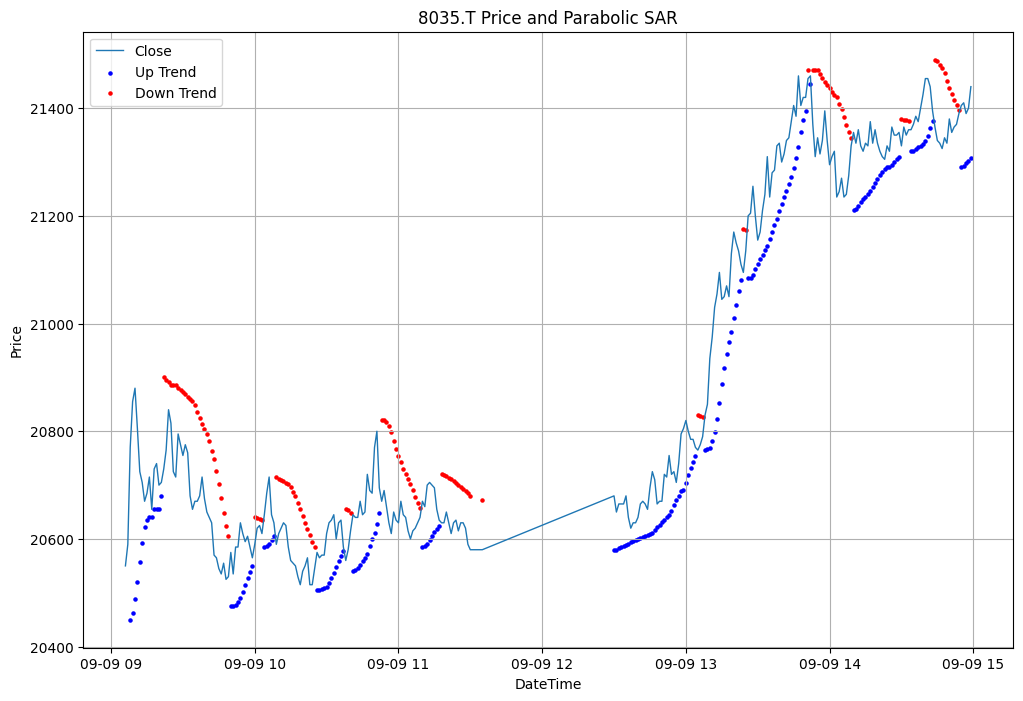

In [9]:
psar_bull = data.loc[data['Trend']==1]['PSAR']
psar_bear = data.loc[data['Trend']==0]['PSAR']

plt.figure(figsize=(12, 8))

plt.plot(data['Close'], label='Close', linewidth=1)
plt.scatter(psar_bull.index, psar_bull, color='b', s=5, label='Up Trend')
plt.scatter(psar_bear.index, psar_bear, color='r', s=5, label='Down Trend')
plt.xlabel('DateTime')
plt.ylabel('Price')

plt.title(f'{ticker} Price and Parabolic SAR')
plt.legend()
plt.grid()

plt.show()